# FAIDM Group Project: CRISP-DM Analysis
## Student Performance Prediction & Clustering
### Open University Learning Analytics Dataset (OULAD)

---

**Module:** WM9QG-15 Fundamentals of AI and Data Mining

**Dataset:** OULAD Mega Table (pre-merged from 7 source files)

**Tasks:**
1. **Predictive Model** (Supervised ML): Predict student final outcomes
2. **Clustering Model** (Unsupervised ML): Segment students by engagement patterns

---

# 0️⃣ Introduction

This notebook follows the **CRISP-DM** (Cross-Industry Standard Process for Data Mining) methodology:

1. **Business Understanding** - Define objectives and success criteria
2. **Data Understanding** - Explore and visualize the data
3. **Data Preparation** - Clean, transform, and engineer features
4. **Modelling** - Build predictive and clustering models
5. **Evaluation** - Assess model performance
6. **Deployment** - Recommendations for implementation

**Prerequisites:** Run `Create_Mega_Table.ipynb` first to generate `oulad_mega_table.csv`

# 1️⃣ Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, silhouette_score, davies_bouldin_score)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries loaded successfully!")
print("-" * 60)

All libraries loaded successfully!
------------------------------------------------------------


---

# 2️⃣ Phase 1: Business Understanding

## 2.1 Business Objectives

The Open University wants to:
1. **Identify at-risk students early** for timely intervention
2. **Understand student engagement patterns** to improve course design
3. **Reduce dropout rates** and improve pass rates

## 2.2 Data Mining Goals

| Task | Type | Goal | Success Metric |
|------|------|------|----------------|
| Task 1 | Classification | Predict Pass/Distinction vs Fail/Withdrawn | AUC-ROC > 0.75 |
| Task 2 | Clustering | Segment students into meaningful groups | Silhouette > 0.2 |

## 2.3 Success Criteria

- Predictive model achieves **>70% accuracy** and **>0.75 AUC-ROC**
- Clusters are **interpretable** and map to distinct outcomes
- Early indicators (first 2 weeks) have predictive power
- Recommendations are **actionable** for university staff

---

# 3️⃣ Phase 2: Data Understanding

## 3.1 Load the Mega Table

In [2]:
# Load the pre-merged mega table
# UPDATE THIS PATH if your file is in a different location
DATA_FILE = 'oulad_mega_table.csv'

print(f"Loading data from: {DATA_FILE}")
print("-" * 60)

df = pd.read_csv(DATA_FILE)

print(f"✓ Data loaded successfully!")
print(f"  Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print("-" * 60)

Loading data from: oulad_mega_table.csv
------------------------------------------------------------
✓ Data loaded successfully!
  Shape: 32,593 rows x 68 columns
------------------------------------------------------------


## 3.2 Initial Data Inspection

In [3]:
# First 5 rows
print("First 5 rows of the dataset:")
print("-" * 60)
df.head()

First 5 rows of the dataset:
------------------------------------------------------------


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,student_module_key,module_presentation_length,date_registration,date_unregistration,assess_score_mean,assess_score_std,assess_score_min,assess_score_max,assess_count,assess_submit_day_mean,assess_submit_day_min,assess_submit_day_max,assess_banked_count,assess_days_early_mean,assess_days_early_worst,assess_total_weight,tma_score_mean,tma_count,cma_score_mean,cma_count,exam_score_mean,exam_count,vle_total_clicks,vle_avg_daily_clicks,vle_click_std,vle_max_daily_clicks,vle_first_access_day,vle_last_access_day,vle_active_days,vle_unique_resources,vle_engagement_span,vle_clicks_per_active_day,vle_early_clicks,vle_early_active_days,vle_early_resources,vle_pre_course_clicks,vle_clicks_dataplus,vle_clicks_dualpane,vle_clicks_externalquiz,vle_clicks_folder,vle_clicks_forumng,vle_clicks_glossary,vle_clicks_homepage,vle_clicks_htmlactivity,vle_clicks_oucollaborate,vle_clicks_oucontent,vle_clicks_ouelluminate,vle_clicks_ouwiki,vle_clicks_page,vle_clicks_questionnaire,vle_clicks_quiz,vle_clicks_repeatactivity,vle_clicks_resource,vle_clicks_sharedsubpage,vle_clicks_subpage,vle_clicks_url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,11391_AAA_2013J,268,-159.0,NaN,82.0,3.082207,78.0,85.0,5.0,112.4,18.0,212.0,0.0,1.8,1.0,100.0,82.0,5.0,NaN,NaN,NaN,NaN,934.0,4.765306,7.591224,76.0,-5.0,253.0,40.0,55.0,258.0,23.350000,301.0,6.0,21.0,98.0,0.0,0.0,0.0,0.0,193.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,28400_AAA_2013J,268,-53.0,NaN,66.4,4.335897,60.0,70.0,5.0,114.2,22.0,212.0,0.0,0.0,-4.0,100.0,66.4,5.0,NaN,NaN,NaN,NaN,1435.0,3.337209,3.634240,23.0,-10.0,239.0,80.0,84.0,249.0,17.937500,456.0,14.0,29.0,215.0,10.0,0.0,0.0,0.0,417.0,0.0,324.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,30268_AAA_2013J,268,-92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.0,3.697368,4.056336,23.0,-10.0,12.0,12.0,22.0,22.0,23.416667,281.0,12.0,22.0,102.0,0.0,0.0,0.0,0.0,126.0,0.0,59.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,31604_AAA_2013J,268,-52.0,NaN,76.0,6.892024,71.0,88.0,5.0,112.2,17.0,213.0,0.0,2.0,1.0,100.0,76.0,5.0,NaN,NaN,NaN,NaN,2158.0,3.254902,3.194577,22.0,-10.0,264.0,123.0,82.0,274.0,17.544715,349.0,13.0,24.0,169.0,2.0,0.0,0.0,0.0,634.0,1.0,432.0,0.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,32885_AAA_2013J,268,-176.0,NaN,54.4,20.513410,30.0,75.0,5.0,125.6,26.0,222.0,0.0,-11.4,-21.0,100.0,54.4,5.0,NaN,NaN,NaN,NaN,1034.0,2.937500,3.261895,22.0,-10.0,247.0,70.0,66.0,257.0,14.771429,472.0,17.0,30.0,295.0,0.0,0.0,0.0,0.0,194.0,4.0,204.0,0.0,0.0,494.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0


In [4]:
# Data types
print("Data types:")
print("-" * 60)
print(df.dtypes)
print("-" * 60)
print(f"\nSummary: {df.dtypes.value_counts().to_dict()}")

Data types:
------------------------------------------------------------
code_module                   object
code_presentation             object
id_student                     int64
gender                        object
region                        object
                              ...   
vle_clicks_repeatactivity    float64
vle_clicks_resource          float64
vle_clicks_sharedsubpage     float64
vle_clicks_subpage           float64
vle_clicks_url               float64
Length: 68, dtype: object
------------------------------------------------------------

Summary: {dtype('float64'): 54, dtype('O'): 10, dtype('int64'): 4}


In [5]:
# Summary statistics for numerical columns
print("Summary statistics (numerical):")
print("-" * 60)
df.describe()

Summary statistics (numerical):
------------------------------------------------------------


,id_student,num_of_prev_attempts,studied_credits,module_presentation_length,date_registration,date_unregistration,assess_score_mean,assess_score_std,assess_score_min,assess_score_max,assess_count,assess_submit_day_mean,assess_submit_day_min,assess_submit_day_max,assess_banked_count,assess_days_early_mean,assess_days_early_worst,assess_total_weight,tma_score_mean,tma_count,cma_score_mean,cma_count,exam_score_mean,exam_count,vle_total_clicks,vle_avg_daily_clicks,vle_click_std,vle_max_daily_clicks,vle_first_access_day,vle_last_access_day,vle_active_days,vle_unique_resources,vle_engagement_span,vle_clicks_per_active_day,vle_early_clicks,vle_early_active_days,vle_early_resources,vle_pre_course_clicks,vle_clicks_dataplus,vle_clicks_dualpane,vle_clicks_externalquiz,vle_clicks_folder,vle_clicks_forumng,vle_clicks_glossary,vle_clicks_homepage,vle_clicks_htmlactivity,vle_clicks_oucollaborate,vle_clicks_oucontent,vle_clicks_ouelluminate,vle_clicks_ouwiki,vle_clicks_page,vle_clicks_questionnaire,vle_clicks_quiz,vle_clicks_repeatactivity,vle_clicks_resource,vle_clicks_sharedsubpage,vle_clicks_subpage,vle_clicks_url
count,3.259300e+04,32593.000000,32593.000000,32593.000000,32548.000000,10072.000000,25820.000000,23301.000000,25820.000000,25820.000000,25843.000000,25843.000000,25843.000000,25843.000000,25843.000000,25842.000000,25842.000000,25843.000000,24788.000000,24820.000000,15100.000000,15100.000000,4959.000000,4959.0,29228.000000,29228.000000,28993.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,28081.000000,28081.000000,28081.000000,23809.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000
mean,7.066877e+05,0.163225,79.758691,256.010125,-69.411300,49.757645,72.768254,13.243276,55.664679,86.544191,6.722865,98.174340,23.268545,167.582014,0.073869,11.934476,-4.166783,85.760825,71.196709,3.958622,79.157648,4.670662,65.572898,1.0,1355.039654,3.268088,5.449157,53.135281,-8.224374,177.294204,61.862563,67.075955,185.518578,19.042236,220.622556,9.411844,22.603290,90.215759,1.624059,0.708772,2.199672,0.185439,272.799713,3.009511,237.753661,0.316101,3.728411,383.426954,1.335295,30.604626,2.177056,2.215820,238.854523,0.000308,37.981798,0.005851,116.723074,19.389011
std,5.491673e+05,0.479758,41.071900,13.179078,49.260522,82.460890,16.374997,7.600832,22.193388,17.104197,3.773957,43.101347,14.715992,75.818072,0.599447,26.364299,14.867160,63.189622,15.911199,1.621883,17.193266,2.026208,20.579186,0.0,1733.546045,1.226142,5.117888,95.449179,13.113730,90.146308,54.027412,54.953382,92.447016,11.576835,288.827634,6.998377,17.938367,143.795385,7.066196,2.779416,8.483000,0.816879,597.674199,35.574016,320.220555,1.452273,10.952296,657.475160,7.783136,88.393704,5.671843,7.102789,466.344205,0.031498,72.719075,0.102988,163.768722,36.143563
min,3.733000e+03,0.000000,30.000000,234.000000,-322.000000,-365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-11.000000,-4.000000,0.000000,-187.000000,-372.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,-25.000000,-25.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.085730e+05,0.000000,60.000000,241.000000,-100.000000,-2.000000,64.666667,7.767453,42.000000,80.000000,4.000000,67.142857,17.000000,117.000000,0.000000,-1.500000,-6.000000,25.000000,62.166667,3.000000,71.571429,3.000000,51.000000,1.0,260.750000,2.364436,2.543923,16.000000,-17.000000,96.000000,18.000000,27.000000,104.000000,11.207887,47.000000,4.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000

In [6]:
# Summary statistics for categorical columns
print("Summary statistics (categorical):")
print("-" * 60)
df.describe(include='object')

Summary statistics (categorical):
------------------------------------------------------------


,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result,student_module_key
count,32593,32593,32593,32593,32593,31482,32593,32593,32593,32593
unique,7,4,2,13,5,10,3,2,4,32593
top,BBB,2014J,M,Scotland,A Level or Equivalent,20-30%,0-35,N,Pass,11391_AAA_2013J
freq,7909,11260,17875,3446,14045,3654,22944,29429,12361,1


## 3.3 Check for Missing Values

In [7]:
print("Missing values per column:")
print("-" * 60)

missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

# Show only columns with missing values
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
    print("-" * 60)
    print(f"\n⚠️ {len(missing_df)} columns have missing values")
    print("Note: Missing VLE/assessment values = students with no activity")
else:
    print("No missing values found!")
print("-" * 60)

Missing values per column:
------------------------------------------------------------
                           Missing Count  Missing %
exam_score_mean                    27634      84.79
exam_count                         27634      84.79
date_unregistration                22521      69.10
cma_count                          17493      53.67
cma_score_mean                     17493      53.67
assess_score_std                    9292      28.51
vle_pre_course_clicks               8784      26.95
tma_score_mean                      7805      23.95
tma_count                           7773      23.85
assess_score_max                    6773      20.78
assess_score_mean                   6773      20.78
assess_score_min                    6773      20.78
assess_days_early_worst             6751      20.71
assess_days_early_mean              6751      20.71
assess_total_weight                 6750      20.71
assess_submit_day_mean              6750      20.71
assess_count                

## 3.4 Check for Duplicate Rows

In [8]:
print("Duplicate rows check:")
print("-" * 60)
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("⚠️ Duplicates found - will be removed during preparation")
else:
    print("✓ No duplicates found")
print("-" * 60)

Duplicate rows check:
------------------------------------------------------------
Number of duplicate rows: 0
✓ No duplicates found
------------------------------------------------------------


## 3.5 Explore the Target Variable (final_result)

In [9]:
print("Target variable distribution (final_result):")
print("-" * 60)

result_counts = df['final_result'].value_counts()
result_pct = df['final_result'].value_counts(normalize=True) * 100

for result in result_counts.index:
    print(f"  {result}: {result_counts[result]:,} ({result_pct[result]:.1f}%)")

print("-" * 60)
print(f"\n⚠️ Class imbalance detected - will use stratified sampling")

Target variable distribution (final_result):
------------------------------------------------------------
  Pass: 12,361 (37.9%)
  Withdrawn: 10,156 (31.2%)
  Fail: 7,052 (21.6%)
  Distinction: 3,024 (9.3%)
------------------------------------------------------------

⚠️ Class imbalance detected - will use stratified sampling


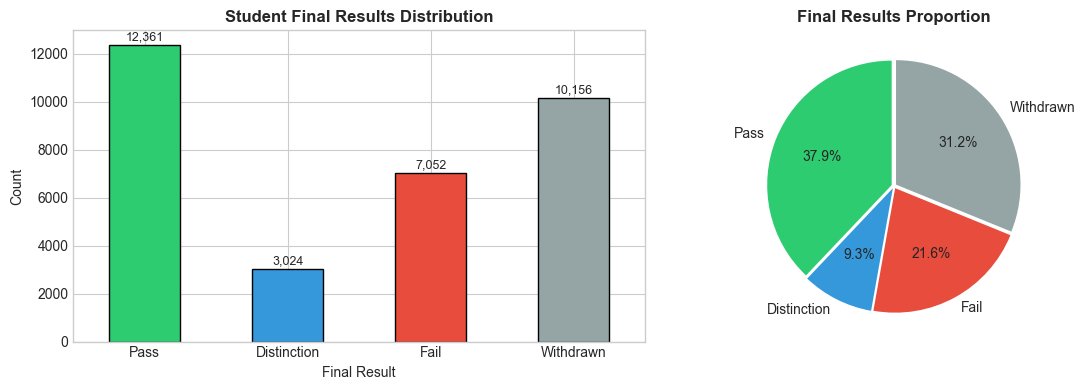

In [10]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
order = ['Pass', 'Distinction', 'Fail', 'Withdrawn']

# Bar chart
result_counts.reindex(order).plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Student Final Results Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Final Result')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Add count labels on bars
for i, v in enumerate(result_counts.reindex(order)):
    axes[0].text(i, v + 200, f'{v:,}', ha='center', fontsize=9)

# Pie chart
axes[1].pie(result_counts.reindex(order), labels=order, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.02]*4)
axes[1].set_title('Final Results Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 3.6 Explore Demographic Variables

In [11]:
# Categorical variable distributions
categorical_cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']

print("Categorical variable distributions:")
print("-" * 60)

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())
print("-" * 60)

Categorical variable distributions:
------------------------------------------------------------

gender:
gender
M    17875
F    14718
Name: count, dtype: int64

region:
region
Scotland                3446
East Anglian Region     3340
London Region           3216
South Region            3092
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2086
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: count, dtype: int64

highest_education:
highest_education
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: count, dtype: int64

imd_band:
imd_band
20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%

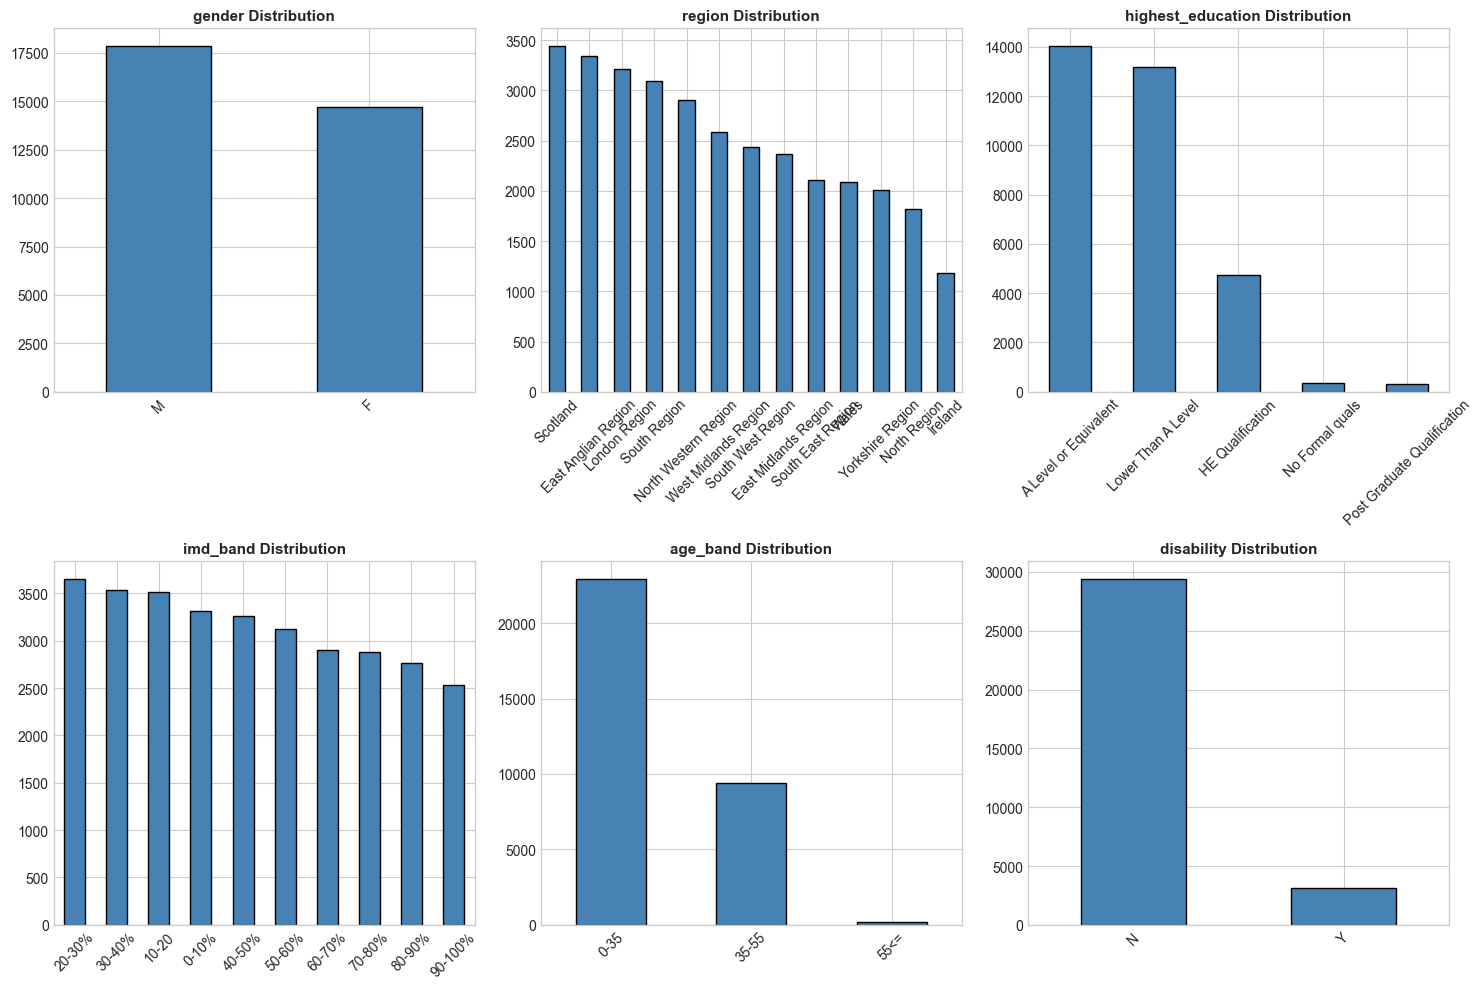

In [12]:
# Visualize demographics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        df[col].value_counts().plot(kind='bar', ax=axes[i], color='steelblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

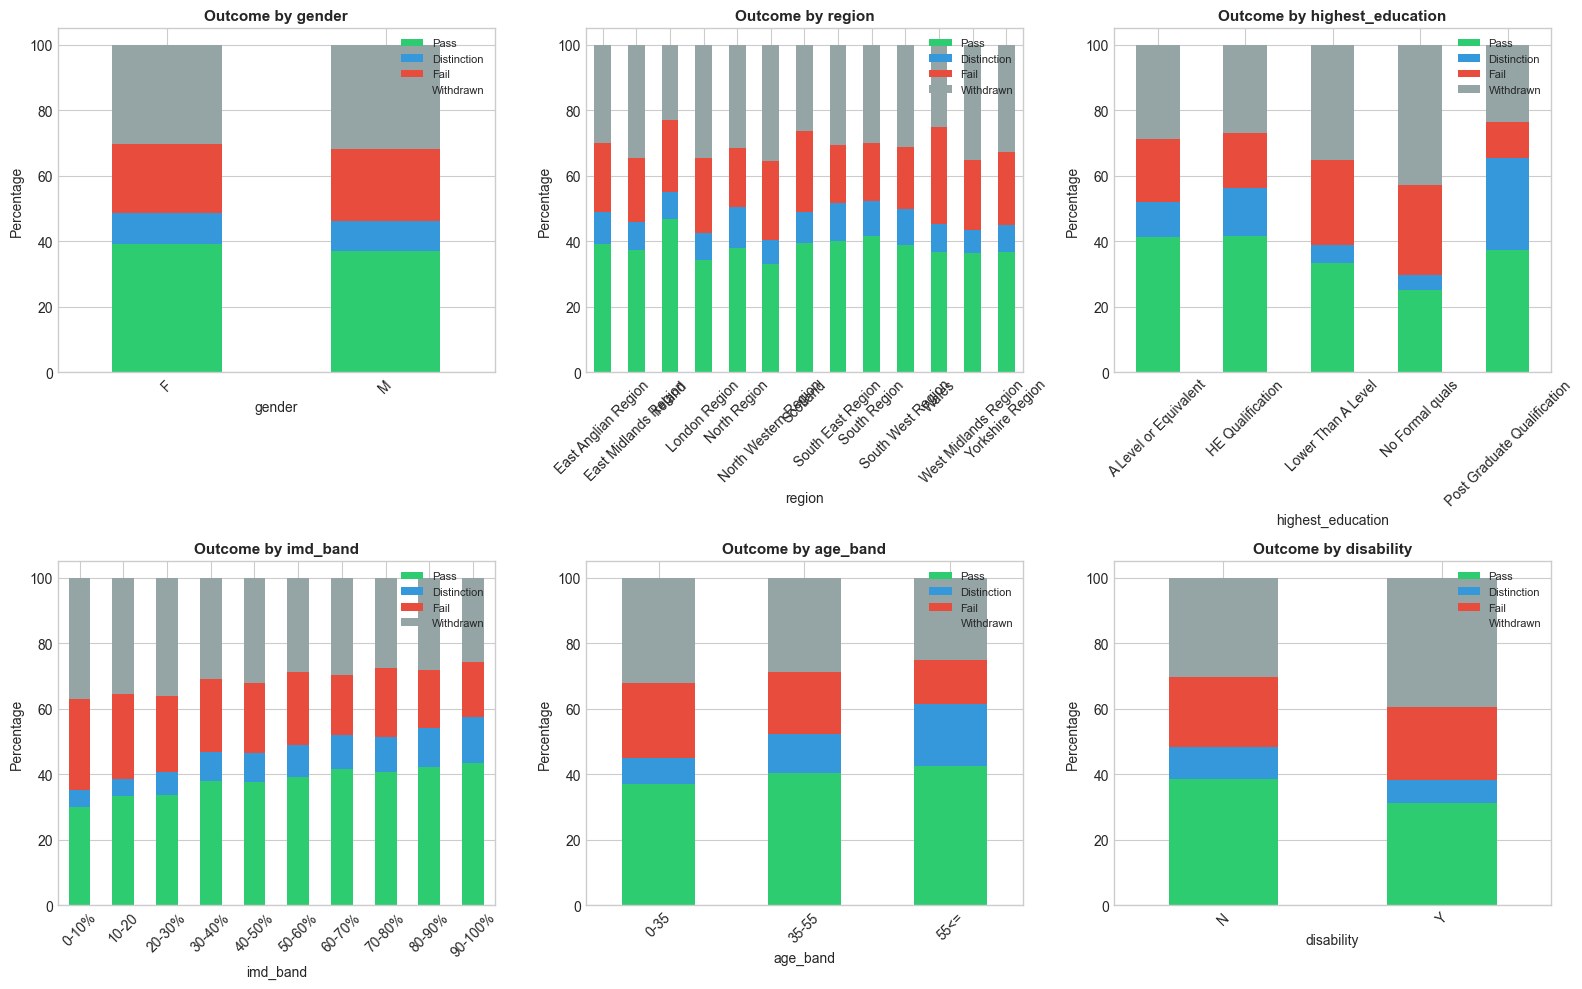

In [13]:
# Final result by demographics (stacked bar charts)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        ct = pd.crosstab(df[col], df['final_result'], normalize='index') * 100
        # Reorder columns
        col_order = [c for c in ['Pass', 'Distinction', 'Fail', 'Withdrawn'] if c in ct.columns]
        ct[col_order].plot(
            kind='bar', stacked=True, ax=axes[i],
            color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
        axes[i].set_title(f'Outcome by {col}', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Percentage')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## 3.7 Explore Numerical Variables

In [14]:
# Key numerical features to explore
key_numerical = ['vle_total_clicks', 'vle_active_days', 'assess_score_mean', 
                 'vle_early_clicks', 'studied_credits', 'num_of_prev_attempts']

# Filter to existing columns
key_numerical = [c for c in key_numerical if c in df.columns]

print("Key numerical variable statistics:")
print("-" * 60)
print(df[key_numerical].describe())

Key numerical variable statistics:
------------------------------------------------------------
       vle_total_clicks  vle_active_days  assess_score_mean  vle_early_clicks  \
count      29228.000000     29228.000000       25820.000000      28081.000000   
mean        1355.039654        61.862563          72.768254        220.622556   
std         1733.546045        54.027412          16.374997        288.827634   
min            1.000000         1.000000           0.000000          1.000000   
25%          260.750000        18.000000          64.666667         47.000000   
50%          739.500000        47.000000          76.000000        128.000000   
75%         1770.000000        92.000000          84.545455        283.000000   
max        24139.000000       286.000000         100.000000       5168.000000   

       studied_credits  num_of_prev_attempts  
count     32593.000000          32593.000000  
mean         79.758691              0.163225  
std          41.071900           

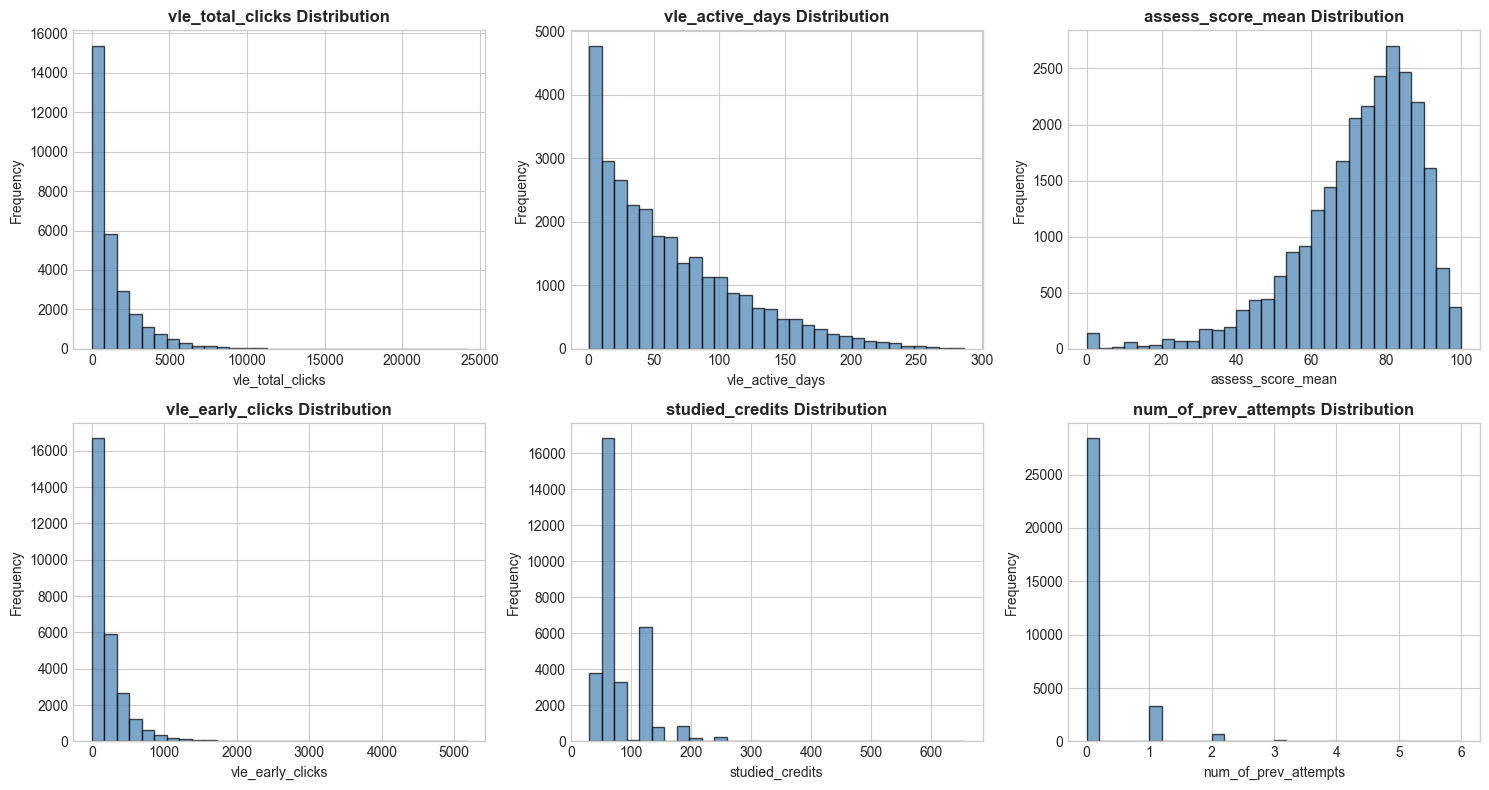

In [15]:
# Histograms for key numerical variables
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(key_numerical):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], color='steelblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col} Distribution', fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

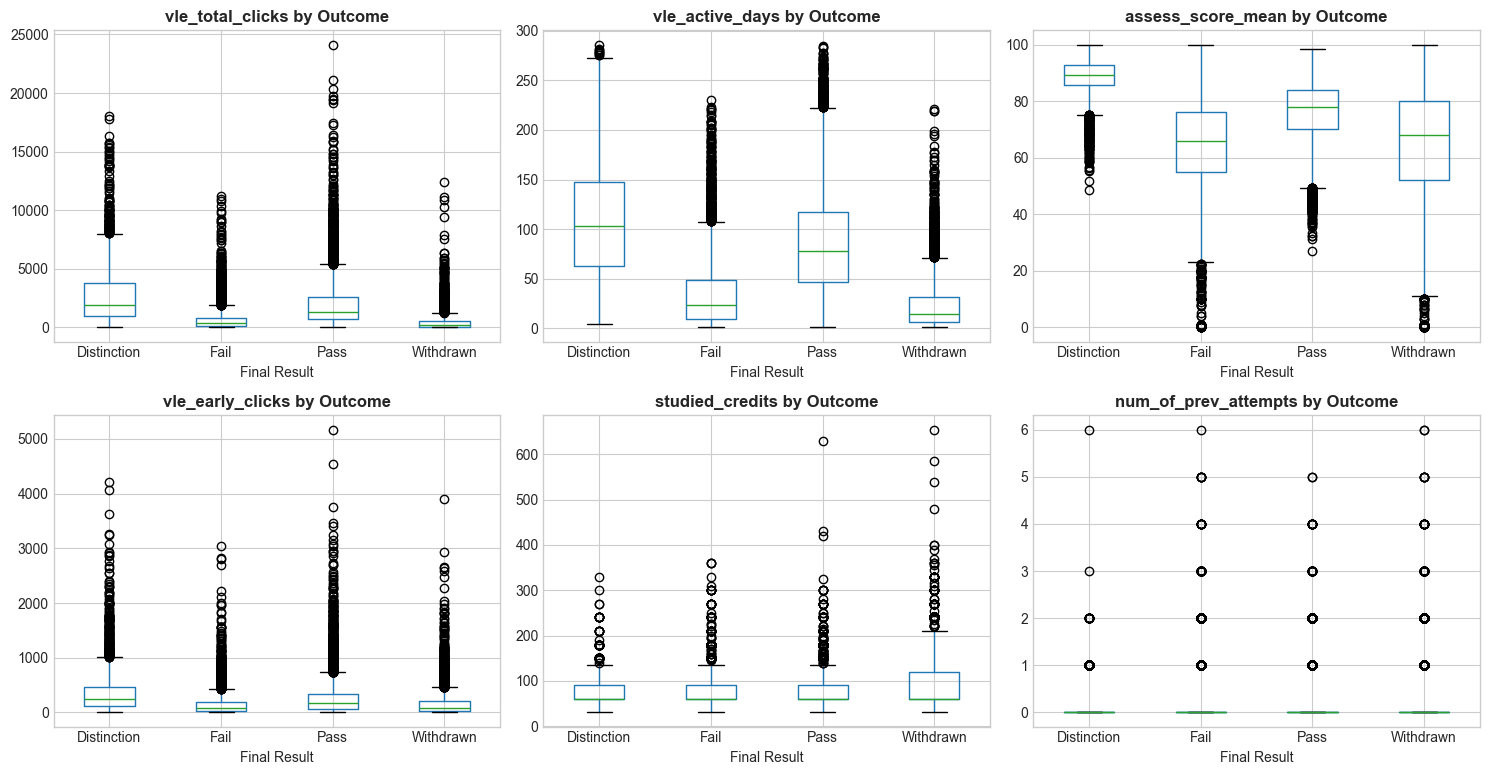

In [16]:
# Box plots by final result
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(key_numerical):
    if i < len(axes):
        df.boxplot(column=col, by='final_result', ax=axes[i])
        axes[i].set_title(f'{col} by Outcome', fontweight='bold')
        axes[i].set_xlabel('Final Result')
        plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

## 3.8 Data Quality Summary

In [17]:
print("=" * 60)
print("DATA UNDERSTANDING SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\n🎯 Target Variable: final_result")
print(f"   - Pass: {result_pct.get('Pass', 0):.1f}%")
print(f"   - Distinction: {result_pct.get('Distinction', 0):.1f}%")
print(f"   - Fail: {result_pct.get('Fail', 0):.1f}%")
print(f"   - Withdrawn: {result_pct.get('Withdrawn', 0):.1f}%")

print(f"\n⚠️ Data Quality Issues:")
print(f"   - Missing values: {len(missing_df)} columns affected")
print(f"   - Duplicate rows: {duplicates}")
print(f"   - Class imbalance: Yes (need stratified sampling)")

print(f"\n📝 Notes for Data Preparation:")
print(f"   - Fill missing VLE values with 0 (no activity)")
print(f"   - Handle imd_band missing values")
print(f"   - Encode categorical variables")
print(f"   - Scale numerical features for some models")
print("=" * 60)

DATA UNDERSTANDING SUMMARY

📊 Dataset Shape: 32,593 rows x 68 columns

🎯 Target Variable: final_result
   - Pass: 37.9%
   - Distinction: 9.3%
   - Fail: 21.6%
   - Withdrawn: 31.2%

⚠️ Data Quality Issues:
   - Missing values: 55 columns affected
   - Duplicate rows: 0
   - Class imbalance: Yes (need stratified sampling)

📝 Notes for Data Preparation:
   - Fill missing VLE values with 0 (no activity)
   - Handle imd_band missing values
   - Encode categorical variables
   - Scale numerical features for some models


---

# 4️⃣ Phase 3: Data Preparation

## 4.1 Handle Missing Values

In [18]:
print("Step 1: Handle missing values")
print("-" * 60)

# Create a copy for preparation
df_prep = df.copy()

# 1. Create missing indicator for imd_band (as taught in class)
if 'imd_band' in df_prep.columns:
    df_prep['imd_band_missing'] = df_prep['imd_band'].isna().astype(int)
    df_prep['imd_band'] = df_prep['imd_band'].fillna('Unknown')
    print("✓ imd_band: Created missing indicator, filled with 'Unknown'")

# 2. Fill VLE columns with 0 (no activity = 0 clicks)
vle_cols = [c for c in df_prep.columns if c.startswith('vle_')]
df_prep[vle_cols] = df_prep[vle_cols].fillna(0)
print(f"✓ VLE columns ({len(vle_cols)} cols): Filled with 0")

# 3. Fill assessment columns with 0 or appropriate values
assess_cols = [c for c in df_prep.columns if c.startswith('assess_') or 
               c.endswith('_score_mean') or c.endswith('_count')]
df_prep[assess_cols] = df_prep[assess_cols].fillna(0)
print(f"✓ Assessment columns ({len(assess_cols)} cols): Filled with 0")

print("-" * 60)

Step 1: Handle missing values
------------------------------------------------------------
✓ imd_band: Created missing indicator, filled with 'Unknown'
✓ VLE columns (34 cols): Filled with 0
✓ Assessment columns (18 cols): Filled with 0
------------------------------------------------------------


In [19]:
# Use SimpleImputer for any remaining numerical columns (as taught in class)
print("Step 2: Impute remaining numerical columns using median")
print("-" * 60)

from sklearn.impute import SimpleImputer

# Get numerical columns with remaining missing values
num_cols = df_prep.select_dtypes(include=[np.number]).columns.tolist()
cols_with_missing = [c for c in num_cols if df_prep[c].isna().any()]

if cols_with_missing:
    median_imputer = SimpleImputer(strategy='median')
    df_prep[cols_with_missing] = median_imputer.fit_transform(df_prep[cols_with_missing])
    print(f"✓ Imputed {len(cols_with_missing)} columns with median")
else:
    print("✓ No remaining numerical columns need imputation")

# Verify no missing values remain (except in columns we'll drop)
print(f"\nRemaining missing values: {df_prep.isna().sum().sum()}")
print("-" * 60)

Step 2: Impute remaining numerical columns using median
------------------------------------------------------------
✓ Imputed 2 columns with median

Remaining missing values: 0
------------------------------------------------------------


## 4.2 Encode Categorical Variables

In [20]:
print("Step 3: Encode categorical variables")
print("-" * 60)

# One-hot encoding for nominal categories using pd.get_dummies (as taught in class)
nominal_cols = ['gender', 'region', 'disability']

for col in nominal_cols:
    if col in df_prep.columns:
        dummies = pd.get_dummies(df_prep[col], prefix=col, drop_first=True)
        df_prep = pd.concat([df_prep, dummies], axis=1)
        print(f"✓ One-hot encoded {col}: {dummies.shape[1]} new columns")

print("-" * 60)

Step 3: Encode categorical variables
------------------------------------------------------------
✓ One-hot encoded gender: 1 new columns
✓ One-hot encoded region: 12 new columns
✓ One-hot encoded disability: 1 new columns
------------------------------------------------------------


In [21]:
print("Step 4: Ordinal encoding for ordered categories")
print("-" * 60)

# Ordinal encoding for education level (has natural order)
education_order = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}

if 'highest_education' in df_prep.columns:
    df_prep['education_level'] = df_prep['highest_education'].map(education_order)
    print(f"✓ Ordinal encoded highest_education -> education_level")

# Ordinal encoding for age band
age_order = {'0-35': 0, '35-55': 1, '55<=': 2}

if 'age_band' in df_prep.columns:
    df_prep['age_level'] = df_prep['age_band'].map(age_order)
    print(f"✓ Ordinal encoded age_band -> age_level")

# Encode module and presentation
if 'code_module' in df_prep.columns:
    df_prep['module_encoded'] = pd.factorize(df_prep['code_module'])[0]
    print(f"✓ Label encoded code_module -> module_encoded")

if 'code_presentation' in df_prep.columns:
    df_prep['presentation_encoded'] = pd.factorize(df_prep['code_presentation'])[0]
    print(f"✓ Label encoded code_presentation -> presentation_encoded")

# One-hot encode imd_band
if 'imd_band' in df_prep.columns:
    imd_dummies = pd.get_dummies(df_prep['imd_band'], prefix='imd', drop_first=True)
    df_prep = pd.concat([df_prep, imd_dummies], axis=1)
    print(f"✓ One-hot encoded imd_band: {imd_dummies.shape[1]} new columns")

print("-" * 60)

Step 4: Ordinal encoding for ordered categories
------------------------------------------------------------
✓ Ordinal encoded highest_education -> education_level
✓ Ordinal encoded age_band -> age_level
✓ Label encoded code_module -> module_encoded
✓ Label encoded code_presentation -> presentation_encoded
✓ One-hot encoded imd_band: 10 new columns
------------------------------------------------------------


## 4.3 Create Target Variables

In [22]:
print("Step 5: Create target variables")
print("-" * 60)

# Binary target: 1 = Pass/Distinction, 0 = Fail/Withdrawn
df_prep['target_binary'] = df_prep['final_result'].apply(
    lambda x: 1 if x in ['Pass', 'Distinction'] else 0
)

# Multi-class target (for future use)
result_map = {'Withdrawn': 0, 'Fail': 1, 'Pass': 2, 'Distinction': 3}
df_prep['target_multiclass'] = df_prep['final_result'].map(result_map)

print("Binary target distribution (1=Success, 0=Failure):")
print(df_prep['target_binary'].value_counts())
print(f"\nSuccess rate: {df_prep['target_binary'].mean()*100:.1f}%")
print("-" * 60)

Step 5: Create target variables
------------------------------------------------------------
Binary target distribution (1=Success, 0=Failure):
target_binary
0    17208
1    15385
Name: count, dtype: int64

Success rate: 47.2%
------------------------------------------------------------


## 4.4 Create Additional Features

In [23]:
print("Step 6: Create additional derived features")
print("-" * 60)

# Registration timing features
if 'date_registration' in df_prep.columns:
    df_prep['registered_early'] = (df_prep['date_registration'] < 0).astype(int)
    df_prep['days_before_start'] = df_prep['date_registration'].apply(lambda x: abs(x) if x < 0 else 0)
    print("✓ Created: registered_early, days_before_start")

# Withdrawal indicator
if 'date_unregistration' in df_prep.columns:
    df_prep['withdrew'] = df_prep['date_unregistration'].notna().astype(int)
    print("✓ Created: withdrew")

# Engagement ratios (handle division by zero)
if 'vle_total_clicks' in df_prep.columns and 'vle_active_days' in df_prep.columns:
    df_prep['engagement_intensity'] = df_prep['vle_total_clicks'] / df_prep['vle_active_days'].replace(0, 1)
    print("✓ Created: engagement_intensity")

# Early engagement ratio
if 'vle_early_clicks' in df_prep.columns and 'vle_total_clicks' in df_prep.columns:
    df_prep['early_engagement_ratio'] = df_prep['vle_early_clicks'] / df_prep['vle_total_clicks'].replace(0, 1)
    print("✓ Created: early_engagement_ratio")

print("-" * 60)

Step 6: Create additional derived features
------------------------------------------------------------
✓ Created: registered_early, days_before_start
✓ Created: withdrew
✓ Created: engagement_intensity
✓ Created: early_engagement_ratio
------------------------------------------------------------


## 4.5 Select Features for Modelling

In [24]:
print("Step 7: Select features for modelling")
print("-" * 60)

# Columns to exclude from features
exclude_cols = [
    'id_student', 'student_module_key', 'code_module', 'code_presentation',
    'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability',
    'final_result', 'target_binary', 'target_multiclass',
    'date_registration', 'date_unregistration'
]

# Get all numerical and boolean columns
feature_cols = [col for col in df_prep.columns 
                if col not in exclude_cols 
                and df_prep[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool', 'uint8']]

print(f"Total features selected: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")
print("-" * 60)

Step 7: Select features for modelling
------------------------------------------------------------
Total features selected: 89

Feature list:
   1. num_of_prev_attempts
   2. studied_credits
   3. module_presentation_length
   4. assess_score_mean
   5. assess_score_std
   6. assess_score_min
   7. assess_score_max
   8. assess_count
   9. assess_submit_day_mean
  10. assess_submit_day_min
  11. assess_submit_day_max
  12. assess_banked_count
  13. assess_days_early_mean
  14. assess_days_early_worst
  15. assess_total_weight
  16. tma_score_mean
  17. tma_count
  18. cma_score_mean
  19. cma_count
  20. exam_score_mean
  21. exam_count
  22. vle_total_clicks
  23. vle_avg_daily_clicks
  24. vle_click_std
  25. vle_max_daily_clicks
  26. vle_first_access_day
  27. vle_last_access_day
  28. vle_active_days
  29. vle_unique_resources
  30. vle_engagement_span
  31. vle_clicks_per_active_day
  32. vle_early_clicks
  33. vle_early_active_days
  34. vle_early_resources
  35. vle_pre_course_

## 4.6 Correlation Analysis

In [25]:
print("Step 8: Correlation analysis with target")
print("-" * 60)

# Calculate correlation with binary target
correlations = df_prep[feature_cols + ['target_binary']].corr()['target_binary'].drop('target_binary')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Top 15 features correlated with success (absolute correlation):")
print("-" * 60)
for i, (feat, corr) in enumerate(correlations_sorted.head(15).items(), 1):
    direction = '+' if correlations[feat] > 0 else '-'
    print(f"  {i:2}. {feat}: {direction}{corr:.4f}")
print("-" * 60)

Step 8: Correlation analysis with target
------------------------------------------------------------
Top 15 features correlated with success (absolute correlation):
------------------------------------------------------------
   1. vle_last_access_day: +0.7826
   2. assess_submit_day_max: +0.7793
   3. vle_engagement_span: +0.7770
   4. assess_submit_day_mean: +0.7552
   5. tma_count: +0.7203
   6. assess_count: +0.7147
   7. assess_total_weight: +0.6486
   8. vle_active_days: +0.6260
   9. assess_score_max: +0.6139
  10. assess_score_mean: +0.6013
  11. tma_score_mean: +0.5835
  12. vle_unique_resources: +0.5335
  13. cma_count: +0.5121
  14. assess_score_min: +0.4767
  15. vle_total_clicks: +0.4766
------------------------------------------------------------


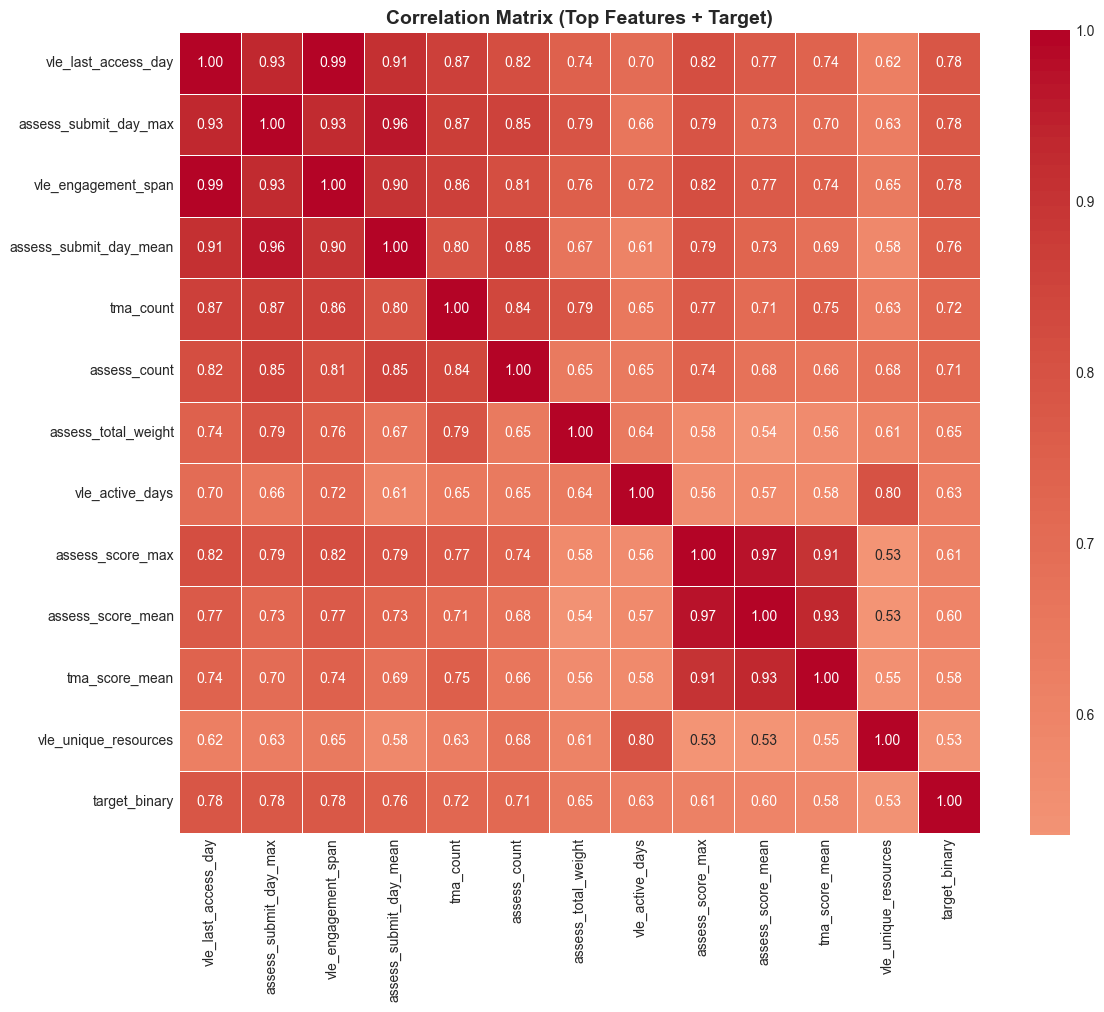

In [26]:
# Visualize correlation heatmap for top features
top_features = correlations_sorted.head(12).index.tolist()
corr_matrix = df_prep[top_features + ['target_binary']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=0.5)
plt.title('Correlation Matrix (Top Features + Target)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.7 Prepare Final Dataset

In [27]:
print("Step 9: Prepare final feature matrix and target")
print("-" * 60)

# Create feature matrix X and target y
X = df_prep[feature_cols].copy()
y = df_prep['target_binary'].copy()

# Handle any infinities
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Feature matrix X: {X.shape}")
print(f"Target vector y: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print("-" * 60)

Step 9: Prepare final feature matrix and target
------------------------------------------------------------
Feature matrix X: (32593, 89)
Target vector y: (32593,)
Target distribution: {0: 17208, 1: 15385}
------------------------------------------------------------


In [28]:
# Save prepared dataset
df_prep.to_csv('oulad_prepared.csv', index=False)
print("\n✓ Prepared dataset saved to 'oulad_prepared.csv'")
print(f"  Shape: {df_prep.shape}")


✓ Prepared dataset saved to 'oulad_prepared.csv'
  Shape: (32593, 104)


---

# 5️⃣ Phase 4: Modelling - Task 1 (Predictive Model)

## 5.1 Train-Test Split

In [29]:
print("Step 10: Split data into training and test sets")
print("-" * 60)

# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nTraining target distribution:")
print(f"  Success (1): {y_train.sum():,} ({y_train.mean()*100:.1f}%)")
print(f"  Failure (0): {(y_train==0).sum():,} ({(1-y_train.mean())*100:.1f}%)")
print("-" * 60)

Step 10: Split data into training and test sets
------------------------------------------------------------
Training set: 26,074 samples (80%)
Test set: 6,519 samples (20%)

Training target distribution:
  Success (1): 12,308 (47.2%)
  Failure (0): 13,766 (52.8%)
------------------------------------------------------------


## 5.2 Feature Scaling

In [30]:
print("Step 11: Scale features using StandardScaler")
print("-" * 60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled (mean=0, std=1)")
print(f"  Training set scaled shape: {X_train_scaled.shape}")
print(f"  Test set scaled shape: {X_test_scaled.shape}")
print("-" * 60)

Step 11: Scale features using StandardScaler
------------------------------------------------------------
✓ Features scaled (mean=0, std=1)
  Training set scaled shape: (26074, 89)
  Test set scaled shape: (6519, 89)
------------------------------------------------------------


## 5.3 Train Multiple Models

In [31]:
print("Step 12: Train baseline models")
print("-" * 60)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Store results
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for Logistic Regression, unscaled for tree-based
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }
    
    print(f"  ✓ Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  ✓ AUC-ROC: {results[name]['AUC-ROC']:.4f}")

print("\n" + "-" * 60)

Step 12: Train baseline models
------------------------------------------------------------

Training Logistic Regression...
  ✓ Accuracy: 0.9491
  ✓ AUC-ROC: 0.9866

Training Random Forest...
  ✓ Accuracy: 0.9554
  ✓ AUC-ROC: 0.9889

Training Gradient Boosting...
  ✓ Accuracy: 0.9578
  ✓ AUC-ROC: 0.9901

------------------------------------------------------------


## 5.4 Model Comparison

In [32]:
print("Step 13: Compare model performance")
print("-" * 60)

# Create results dataframe
results_df = pd.DataFrame(results).T
print(results_df.round(4))
print("-" * 60)

# Find best model
best_model_name = results_df['AUC-ROC'].idxmax()
print(f"\n🏆 Best model (by AUC-ROC): {best_model_name}")

Step 13: Compare model performance
------------------------------------------------------------
                     Accuracy  Precision  Recall  F1 Score  AUC-ROC
Logistic Regression    0.9491     0.9253  0.9704    0.9473   0.9866
Random Forest          0.9554     0.9297  0.9795    0.9539   0.9889
Gradient Boosting      0.9578     0.9375  0.9756    0.9562   0.9901
------------------------------------------------------------

🏆 Best model (by AUC-ROC): Gradient Boosting


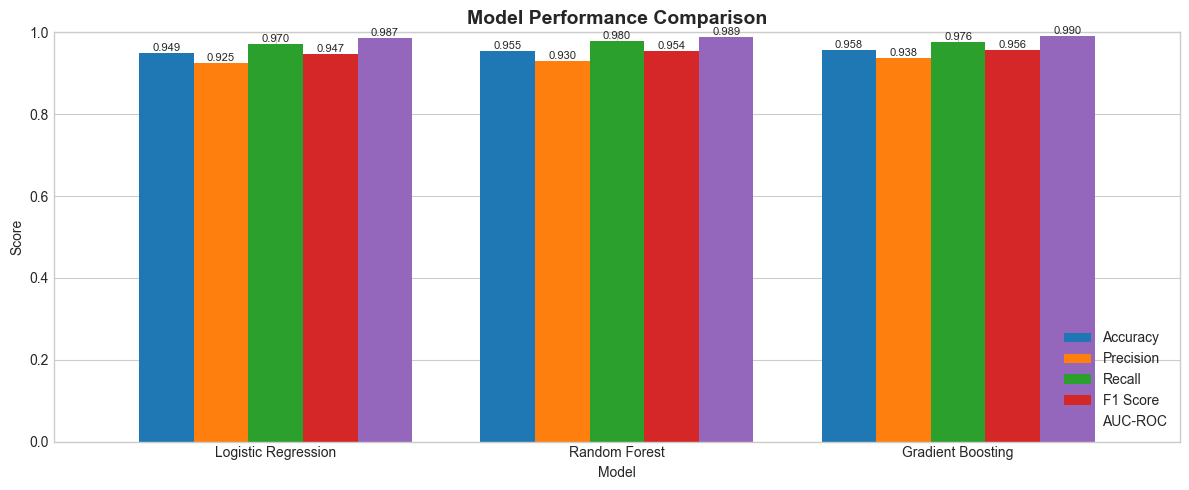

In [33]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 5))

results_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_xticklabels(results_df.index, rotation=0)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

## 5.5 Best Model Analysis (Random Forest)

In [34]:
print("Step 14: Detailed analysis of Random Forest")
print("-" * 60)

# Get Random Forest predictions
rf_model = models['Random Forest']
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Fail/Withdrawn', 'Pass/Distinction']))
print("-" * 60)

Step 14: Detailed analysis of Random Forest
------------------------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

  Fail/Withdrawn       0.98      0.93      0.96      3442
Pass/Distinction       0.93      0.98      0.95      3077

        accuracy                           0.96      6519
       macro avg       0.96      0.96      0.96      6519
    weighted avg       0.96      0.96      0.96      6519

------------------------------------------------------------


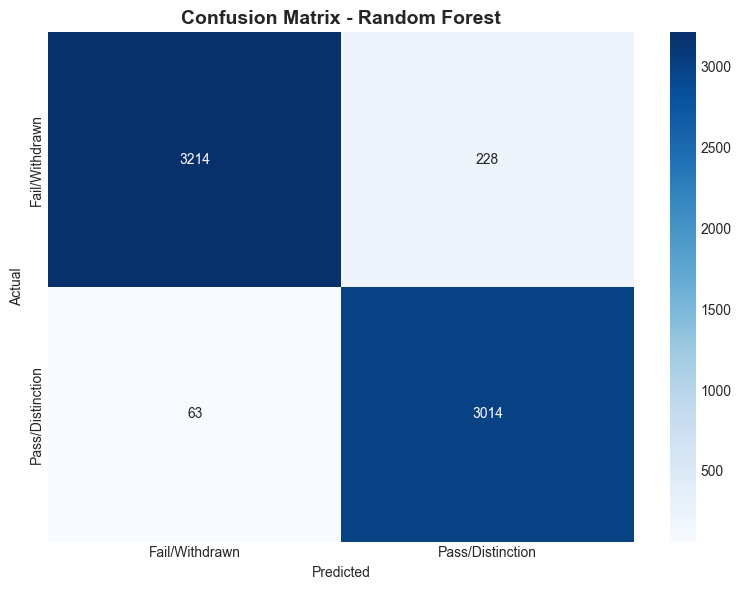

True Negatives (correctly predicted failures): 3,214
True Positives (correctly predicted successes): 3,014
False Positives (predicted success, actually failed): 228
False Negatives (predicted failure, actually succeeded): 63


In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail/Withdrawn', 'Pass/Distinction'],
            yticklabels=['Fail/Withdrawn', 'Pass/Distinction'])
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (correctly predicted failures): {tn:,}")
print(f"True Positives (correctly predicted successes): {tp:,}")
print(f"False Positives (predicted success, actually failed): {fp:,}")
print(f"False Negatives (predicted failure, actually succeeded): {fn:,}")

## 5.6 Feature Importance

In [36]:
print("Step 15: Feature importance analysis")
print("-" * 60)

# Get feature importances from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 most important features:")
print("-" * 60)
for i, row in feature_importance.head(20).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")
print("-" * 60)

Step 15: Feature importance analysis
------------------------------------------------------------
Top 20 most important features:
------------------------------------------------------------
  vle_last_access_day: 0.1401
  assess_submit_day_max: 0.1169
  vle_engagement_span: 0.0886
  assess_submit_day_mean: 0.0855
  assess_total_weight: 0.0661
  assess_count: 0.0407
  tma_count: 0.0360
  assess_score_max: 0.0342
  assess_score_mean: 0.0341
  tma_score_mean: 0.0272
  vle_active_days: 0.0237
  assess_score_std: 0.0228
  vle_clicks_homepage: 0.0225
  assess_score_min: 0.0190
  cma_count: 0.0190
  vle_unique_resources: 0.0178
  exam_score_mean: 0.0155
  vle_total_clicks: 0.0127
  early_engagement_ratio: 0.0125
  vle_clicks_resource: 0.0111
------------------------------------------------------------


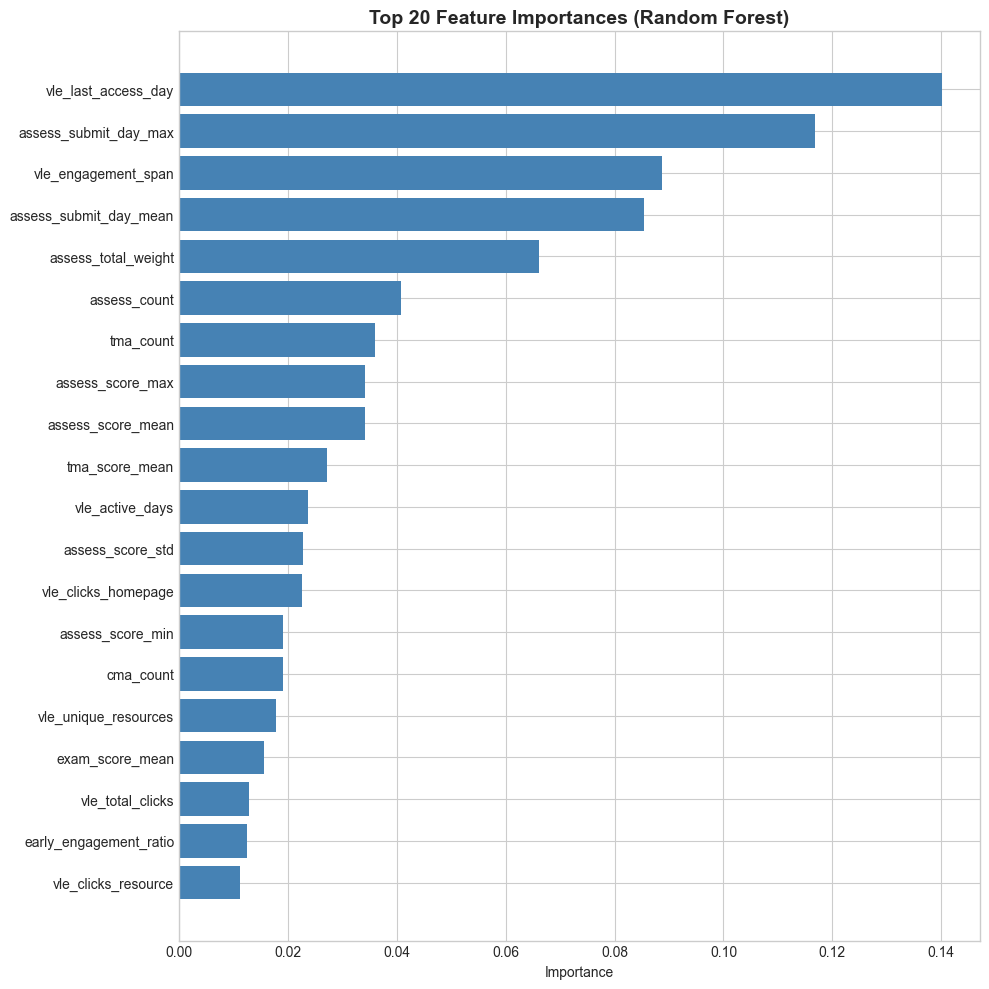

In [37]:
# Visualize feature importance
plt.figure(figsize=(10, 10))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5.7 ROC Curves

Step 16: ROC Curve comparison
------------------------------------------------------------


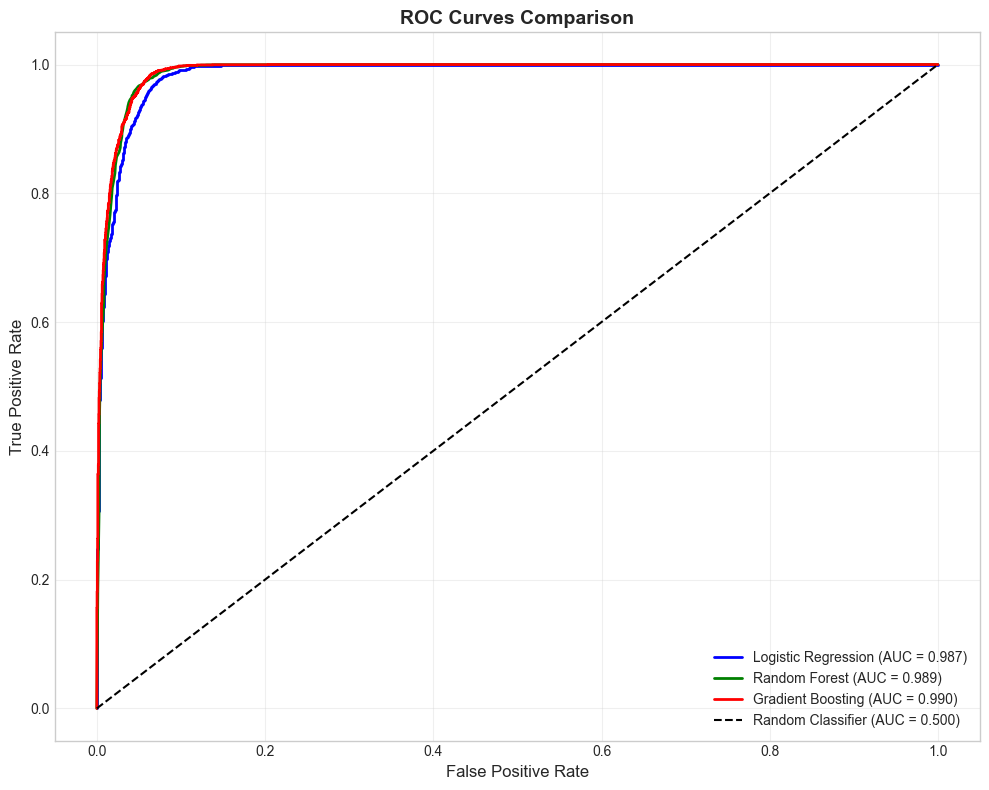

In [38]:
print("Step 16: ROC Curve comparison")
print("-" * 60)

plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red']
for (name, model), color in zip(models.items(), colors):
    if 'Logistic' in name:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.8 Hyperparameter Tuning

In [39]:
print("Step 17: Hyperparameter tuning with GridSearchCV")
print("-" * 60)

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print("\nRunning GridSearchCV (this may take a few minutes)...")

# Create GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "-" * 60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV AUC-ROC: {grid_search.best_score_:.4f}")
print("-" * 60)

Step 17: Hyperparameter tuning with GridSearchCV
------------------------------------------------------------
Parameter grid:
  n_estimators: [100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Running GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

------------------------------------------------------------
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV AUC-ROC: 0.9877
------------------------------------------------------------


In [40]:
# Evaluate tuned model on test set
print("Step 18: Evaluate tuned model on test set")
print("-" * 60)

best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Random Forest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_tuned):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print("-" * 60)

Step 18: Evaluate tuned model on test set
------------------------------------------------------------
Tuned Random Forest Performance:
  Accuracy: 0.9555
  Precision: 0.9289
  Recall: 0.9808
  F1 Score: 0.9542
  AUC-ROC: 0.9891
------------------------------------------------------------


## 5.9 Cross-Validation

In [41]:
print("Step 19: Cross-validation for robust evaluation")
print("-" * 60)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_rf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

print("5-Fold Cross-Validation Results:")
print(f"  Fold scores: {cv_scores.round(4)}")
print(f"  Mean AUC-ROC: {cv_scores.mean():.4f}")
print(f"  Std: {cv_scores.std():.4f}")
print(f"  95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")
print("-" * 60)

Step 19: Cross-validation for robust evaluation
------------------------------------------------------------
5-Fold Cross-Validation Results:
  Fold scores: [0.9878 0.9886 0.987  0.9888 0.9885]
  Mean AUC-ROC: 0.9881
  Std: 0.0007
  95% CI: [0.9868, 0.9894]
------------------------------------------------------------


---

# 6️⃣ Phase 4: Modelling - Task 2 (Clustering Model)

## 6.1 Select Clustering Features

In [42]:
print("Step 20: Select features for clustering")
print("-" * 60)

# Select engagement-focused features for clustering
cluster_features = [
    'vle_total_clicks', 'vle_avg_daily_clicks', 'vle_active_days', 'vle_unique_resources',
    'vle_early_clicks', 'vle_early_active_days', 'vle_pre_course_clicks',
    'assess_score_mean', 'assess_count', 'assess_days_early_mean',
    'studied_credits', 'num_of_prev_attempts'
]

# Keep only available features
cluster_features = [f for f in cluster_features if f in df_prep.columns]

print(f"Using {len(cluster_features)} features for clustering:")
for f in cluster_features:
    print(f"  - {f}")
print("-" * 60)

Step 20: Select features for clustering
------------------------------------------------------------
Using 12 features for clustering:
  - vle_total_clicks
  - vle_avg_daily_clicks
  - vle_active_days
  - vle_unique_resources
  - vle_early_clicks
  - vle_early_active_days
  - vle_pre_course_clicks
  - assess_score_mean
  - assess_count
  - assess_days_early_mean
  - studied_credits
  - num_of_prev_attempts
------------------------------------------------------------


In [43]:
# Prepare clustering data
X_cluster = df_prep[cluster_features].copy()
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale features (important for K-Means)
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

print(f"Clustering data shape: {X_cluster_scaled.shape}")

Clustering data shape: (32593, 12)


## 6.2 Find Optimal Number of Clusters

In [44]:
print("Step 21: Evaluate different numbers of clusters")
print("-" * 60)

K_range = range(2, 11)
inertias = []
silhouettes = []
davies_bouldins = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_cluster_scaled, labels))
    davies_bouldins.append(davies_bouldin_score(X_cluster_scaled, labels))
    
    print(f"k={k}: Silhouette={silhouettes[-1]:.4f}, Davies-Bouldin={davies_bouldins[-1]:.4f}")

print("-" * 60)

Step 21: Evaluate different numbers of clusters
------------------------------------------------------------
k=2: Silhouette=0.3153, Davies-Bouldin=1.3594
k=3: Silhouette=0.2610, Davies-Bouldin=1.3271
k=4: Silhouette=0.2395, Davies-Bouldin=1.4787
k=5: Silhouette=0.2504, Davies-Bouldin=1.4149
k=6: Silhouette=0.2386, Davies-Bouldin=1.4808
k=7: Silhouette=0.2242, Davies-Bouldin=1.4395
k=8: Silhouette=0.2023, Davies-Bouldin=1.5032
k=9: Silhouette=0.2065, Davies-Bouldin=1.4900
k=10: Silhouette=0.1860, Davies-Bouldin=1.4533
------------------------------------------------------------


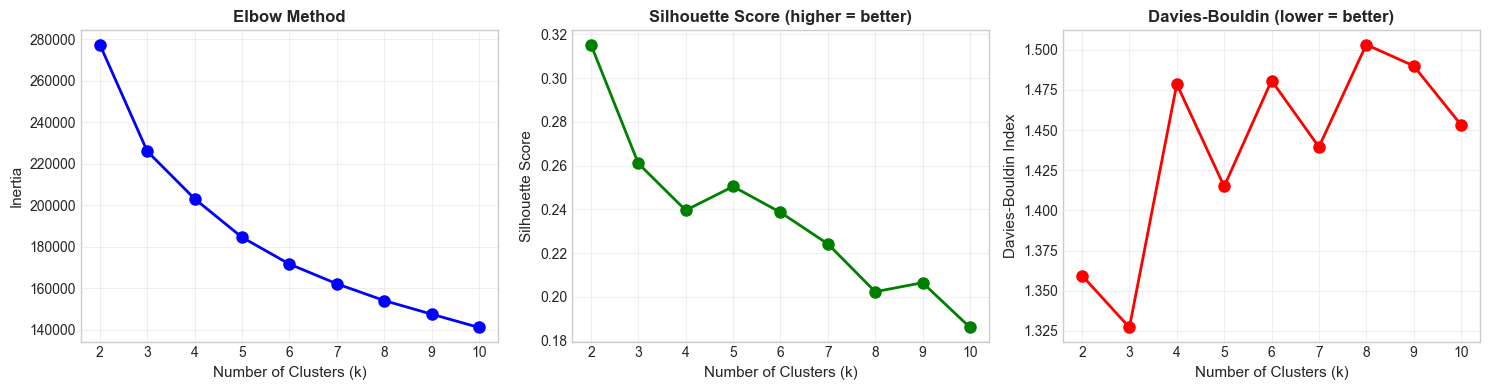

In [45]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette score
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher = better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin
axes[2].plot(K_range, davies_bouldins, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin (lower = better)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.3 Fit Final K-Means Model

In [46]:
print("Step 22: Fit final K-Means model")
print("-" * 60)

# Choose optimal k based on analysis above
# (You can adjust this based on your elbow/silhouette analysis)
OPTIMAL_K = 3

print(f"Selected k = {OPTIMAL_K}")

# Fit K-Means
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Add cluster labels to dataframe
df_prep['cluster'] = cluster_labels

print(f"\nCluster distribution:")
cluster_counts = df_prep['cluster'].value_counts().sort_index()
for c, count in cluster_counts.items():
    pct = count / len(df_prep) * 100
    print(f"  Cluster {c}: {count:,} students ({pct:.1f}%)")

print(f"\nFinal Silhouette Score: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")
print("-" * 60)

Step 22: Fit final K-Means model
------------------------------------------------------------
Selected k = 3

Cluster distribution:
  Cluster 0: 18,522 students (56.8%)
  Cluster 1: 8,505 students (26.1%)
  Cluster 2: 5,566 students (17.1%)

Final Silhouette Score: 0.2610
------------------------------------------------------------


## 6.4 Cluster Profiling

In [47]:
print("Step 23: Profile each cluster")
print("-" * 60)

# Calculate mean values for each cluster
cluster_profiles = df_prep.groupby('cluster')[cluster_features].mean()

print("Cluster centroids (mean values):")
print(cluster_profiles.round(2).T)
print("-" * 60)

Step 23: Profile each cluster
------------------------------------------------------------
Cluster centroids (mean values):
cluster                      0      1        2
vle_total_clicks        920.08  62.89  3957.69
vle_avg_daily_clicks      3.25   1.48     4.07
vle_active_days          53.22   4.77   140.47
vle_unique_resources     58.04   9.79   144.13
vle_early_clicks        137.27  32.85   606.08
vle_early_active_days     7.50   2.41    18.86
vle_pre_course_clicks    40.74  13.10   230.32
assess_score_mean        73.24   9.15    79.86
assess_count              6.36   0.38     9.48
assess_days_early_mean    7.61  -0.20    30.39
studied_credits          74.16  91.55    80.39
num_of_prev_attempts      0.15   0.23     0.11
------------------------------------------------------------


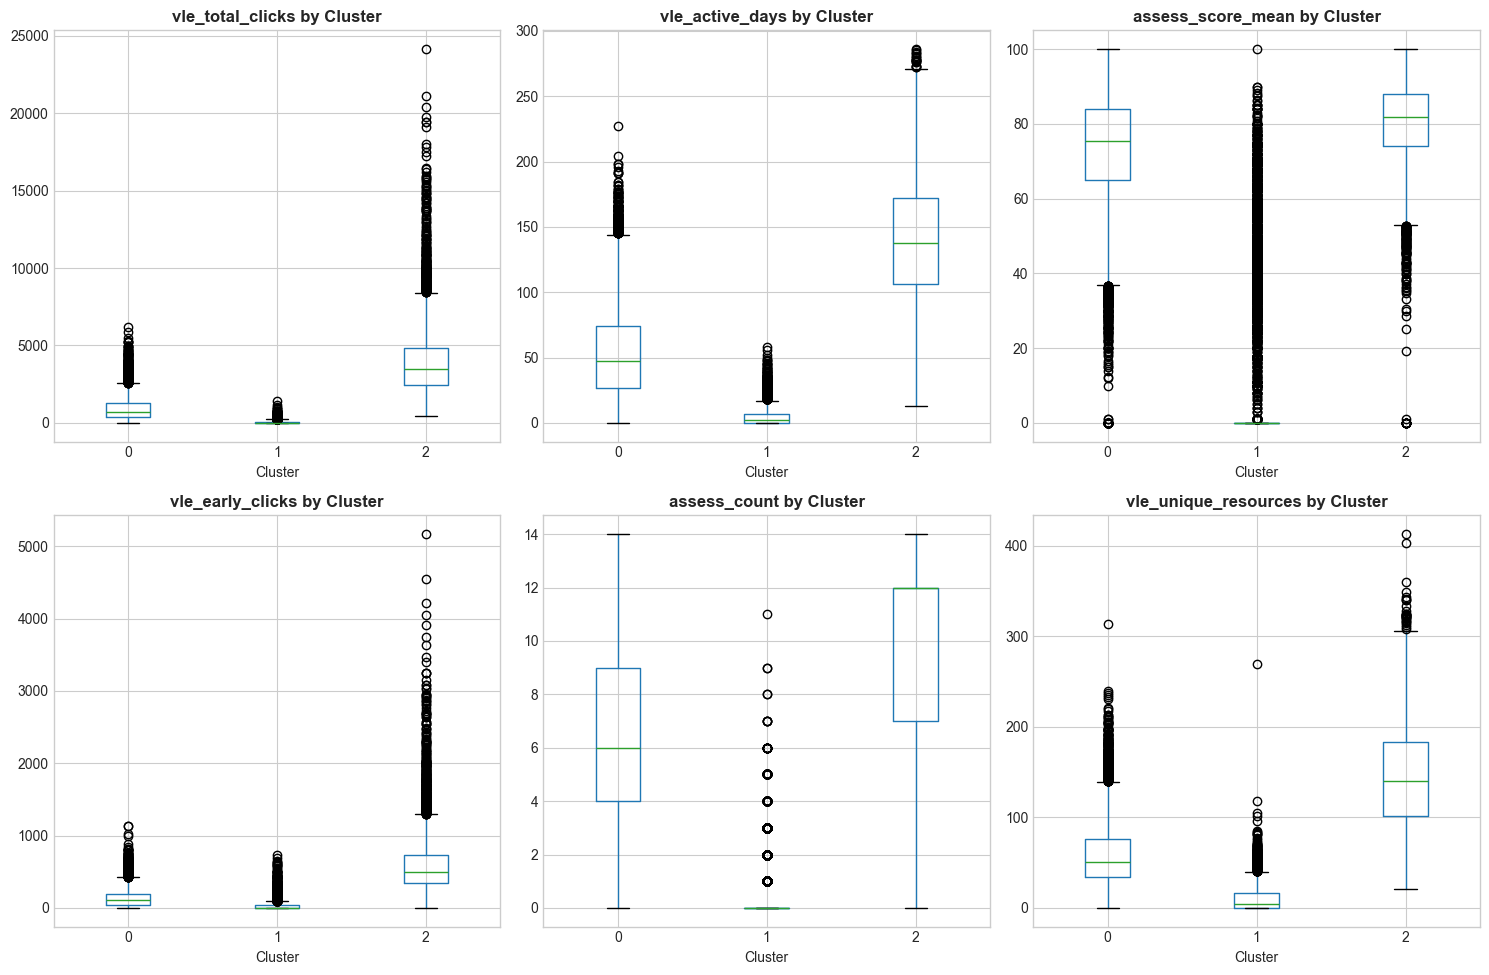

In [48]:
# Visualize cluster profiles
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_features = ['vle_total_clicks', 'vle_active_days', 'assess_score_mean',
                 'vle_early_clicks', 'assess_count', 'vle_unique_resources']
plot_features = [f for f in plot_features if f in cluster_features]

for i, feat in enumerate(plot_features):
    if i < len(axes):
        df_prep.boxplot(column=feat, by='cluster', ax=axes[i])
        axes[i].set_title(f'{feat} by Cluster', fontweight='bold')
        axes[i].set_xlabel('Cluster')
        plt.suptitle('')

plt.tight_layout()
plt.show()

## 6.5 Cluster vs Outcome Analysis

In [49]:
print("Step 24: Analyze clusters vs final outcomes")
print("-" * 60)

# Cross-tabulation
cluster_outcome = pd.crosstab(df_prep['cluster'], df_prep['final_result'], normalize='index') * 100
print("Outcome distribution by cluster (%):")
print(cluster_outcome.round(1))
print("-" * 60)

# Success rate per cluster
success_rate = df_prep.groupby('cluster')['target_binary'].mean() * 100
print("\nSuccess rate (Pass/Distinction) by cluster:")
for c, rate in success_rate.items():
    risk = 'HIGH RISK' if rate < 50 else 'MEDIUM RISK' if rate < 70 else 'LOW RISK'
    print(f"  Cluster {c}: {rate:.1f}% success - {risk}")
print("-" * 60)

Step 24: Analyze clusters vs final outcomes
------------------------------------------------------------
Outcome distribution by cluster (%):
final_result  Distinction  Fail  Pass  Withdrawn
cluster                                         
0                     9.6  24.1  47.8       18.4
1                     0.0  24.8   0.3       74.9
2                    22.3   8.5  62.5        6.6
------------------------------------------------------------

Success rate (Pass/Distinction) by cluster:
  Cluster 0: 57.4% success - MEDIUM RISK
  Cluster 1: 0.3% success - HIGH RISK
  Cluster 2: 84.8% success - LOW RISK
------------------------------------------------------------


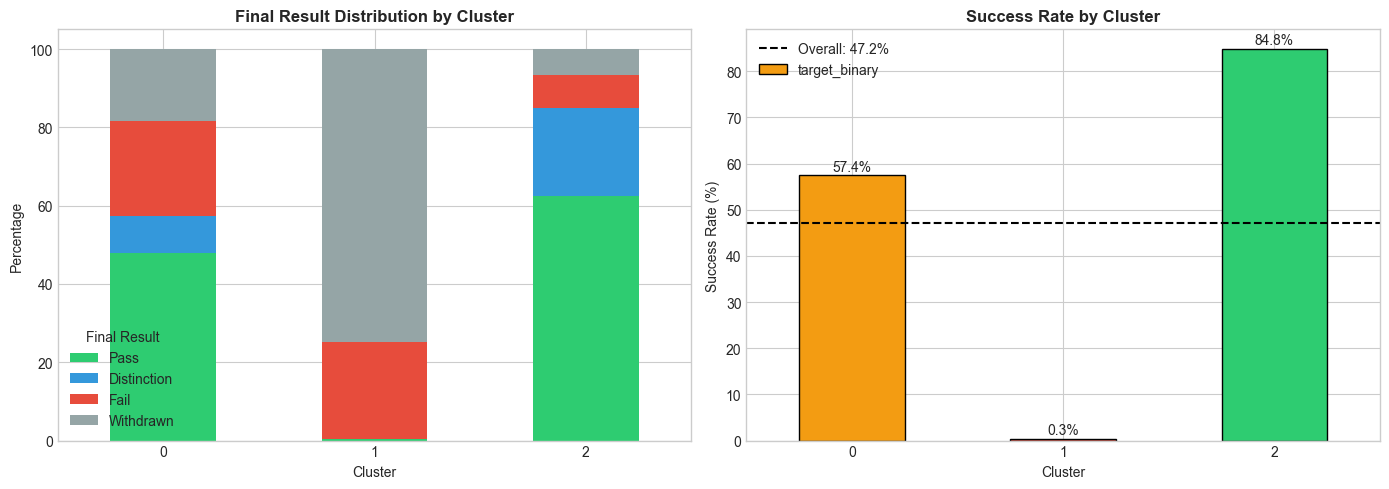

In [50]:
# Visualize cluster outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
order = ['Pass', 'Distinction', 'Fail', 'Withdrawn']
cols_present = [c for c in order if c in cluster_outcome.columns]
cluster_outcome[cols_present].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_title('Final Result Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Final Result')

# Success rate bar chart
colors = ['#e74c3c' if r < 50 else '#f39c12' if r < 70 else '#2ecc71' for r in success_rate]
success_rate.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Success Rate by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Success Rate (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].axhline(y=df_prep['target_binary'].mean()*100, color='black', linestyle='--', 
                label=f'Overall: {df_prep["target_binary"].mean()*100:.1f}%')
axes[1].legend()

# Add value labels
for i, v in enumerate(success_rate):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6.6 PCA Visualization

Step 25: PCA visualization of clusters
------------------------------------------------------------
Explained variance ratio: PC1=47.57%, PC2=11.69%
Total variance explained: 59.26%


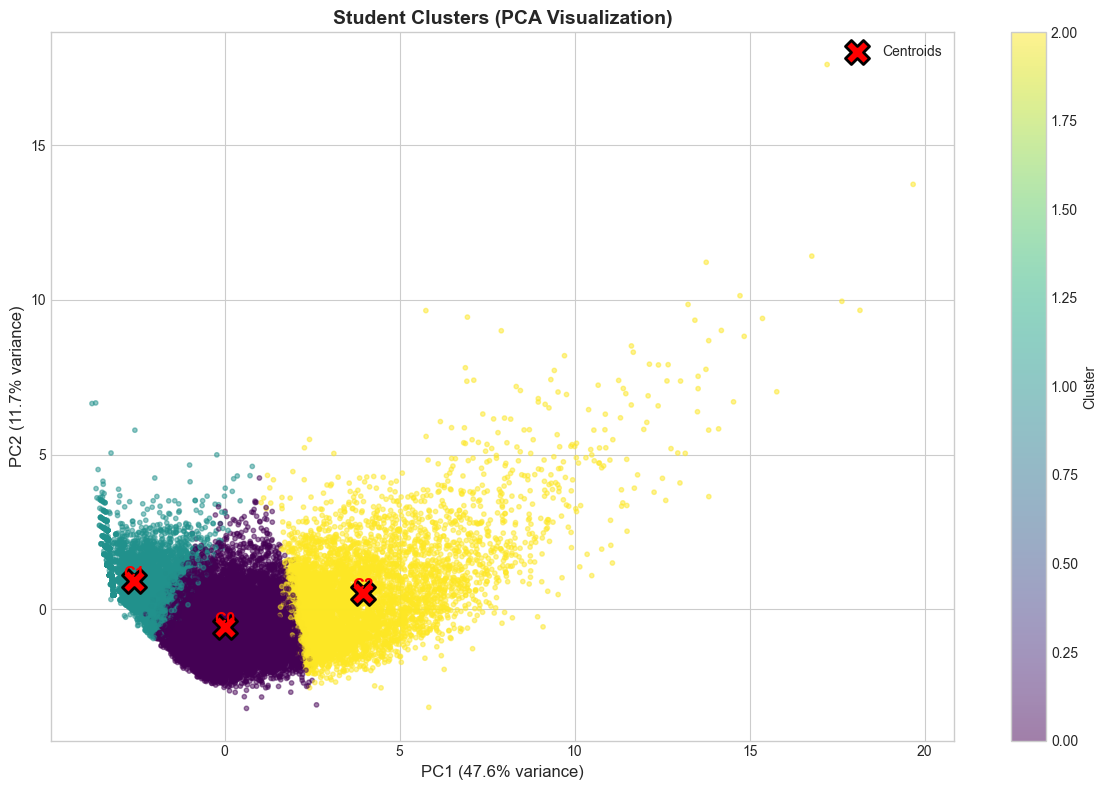

In [51]:
print("Step 25: PCA visualization of clusters")
print("-" * 60)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', 
                      alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')

# Add cluster centroids
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
            s=300, edgecolors='black', linewidths=2, label='Centroids')

# Label centroids
for i, (x, y) in enumerate(centers_pca):
    plt.annotate(f'C{i}', (x, y), fontsize=12, fontweight='bold', 
                 ha='center', va='bottom', color='red')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Student Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 6.7 Cluster Interpretation

In [52]:
print("Step 26: Interpret and name clusters")
print("=" * 60)

# Analyze each cluster based on feature profiles
for c in range(OPTIMAL_K):
    profile = cluster_profiles.loc[c]
    rate = success_rate[c]
    count = cluster_counts[c]
    
    print(f"\n🔹 CLUSTER {c}")
    print(f"   Size: {count:,} students ({count/len(df_prep)*100:.1f}%)")
    print(f"   Success Rate: {rate:.1f}%")
    print(f"   Key characteristics:")
    print(f"     - Total clicks: {profile.get('vle_total_clicks', 0):.0f}")
    print(f"     - Active days: {profile.get('vle_active_days', 0):.0f}")
    print(f"     - Avg score: {profile.get('assess_score_mean', 0):.1f}")
    print(f"     - Early clicks: {profile.get('vle_early_clicks', 0):.0f}")

print("\n" + "=" * 60)
print("\n📝 Suggested cluster names (update based on your analysis):")
print("   Cluster 0: [Describe based on characteristics]")
print("   Cluster 1: [Describe based on characteristics]")
print("   Cluster 2: [Describe based on characteristics]")
print("   Cluster 3: [Describe based on characteristics]")
print("\n   Examples: 'Disengaged', 'Late Starters', 'High Achievers', 'Consistent Learners'")

Step 26: Interpret and name clusters

🔹 CLUSTER 0
   Size: 18,522 students (56.8%)
   Success Rate: 57.4%
   Key characteristics:
     - Total clicks: 920
     - Active days: 53
     - Avg score: 73.2
     - Early clicks: 137

🔹 CLUSTER 1
   Size: 8,505 students (26.1%)
   Success Rate: 0.3%
   Key characteristics:
     - Total clicks: 63
     - Active days: 5
     - Avg score: 9.2
     - Early clicks: 33

🔹 CLUSTER 2
   Size: 5,566 students (17.1%)
   Success Rate: 84.8%
   Key characteristics:
     - Total clicks: 3958
     - Active days: 140
     - Avg score: 79.9
     - Early clicks: 606


📝 Suggested cluster names (update based on your analysis):
   Cluster 0: [Describe based on characteristics]
   Cluster 1: [Describe based on characteristics]
   Cluster 2: [Describe based on characteristics]
   Cluster 3: [Describe based on characteristics]

   Examples: 'Disengaged', 'Late Starters', 'High Achievers', 'Consistent Learners'


---

# 7️⃣ Phase 5: Evaluation Summary

In [53]:
print("=" * 70)
print("                         EVALUATION SUMMARY                          ")
print("=" * 70)

print("\n" + "-" * 70)
print("TASK 1: PREDICTIVE MODEL (Classification)")
print("-" * 70)
print(f"Best Model: Random Forest (Tuned)")
print(f"\nTest Set Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  • F1 Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"  • AUC-ROC:   {roc_auc_score(y_test, y_proba_tuned):.4f}")
print(f"\nCross-Validation (5-fold):")
print(f"  • Mean AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\nTop 5 Predictive Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "-" * 70)
print("TASK 2: CLUSTERING MODEL (Segmentation)")
print("-" * 70)
print(f"Algorithm: K-Means")
print(f"Number of Clusters: {OPTIMAL_K}")
print(f"Silhouette Score: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")
print(f"\nCluster Analysis:")
for c in range(OPTIMAL_K):
    rate = success_rate[c]
    risk = 'HIGH RISK' if rate < 50 else 'MEDIUM RISK' if rate < 70 else 'LOW RISK'
    print(f"  Cluster {c}: {cluster_counts[c]:,} students, {rate:.1f}% success - {risk}")

print("\n" + "=" * 70)
print("SUCCESS CRITERIA CHECK")
print("=" * 70)
auc_check = '✓' if roc_auc_score(y_test, y_proba_tuned) > 0.75 else '✗'
acc_check = '✓' if accuracy_score(y_test, y_pred_tuned) > 0.70 else '✗'
sil_check = '✓' if silhouette_score(X_cluster_scaled, cluster_labels) > 0.2 else '✗'

print(f"  {auc_check} AUC-ROC > 0.75: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print(f"  {acc_check} Accuracy > 70%: {accuracy_score(y_test, y_pred_tuned)*100:.1f}%")
print(f"  {sil_check} Silhouette > 0.2: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")
print("=" * 70)

                         EVALUATION SUMMARY                          

----------------------------------------------------------------------
TASK 1: PREDICTIVE MODEL (Classification)
----------------------------------------------------------------------
Best Model: Random Forest (Tuned)

Test Set Performance:
  • Accuracy:  0.9555
  • Precision: 0.9289
  • Recall:    0.9808
  • F1 Score:  0.9542
  • AUC-ROC:   0.9891

Cross-Validation (5-fold):
  • Mean AUC-ROC: 0.9881 ± 0.0007

Top 5 Predictive Features:
  27. vle_last_access_day: 0.1401
  11. assess_submit_day_max: 0.1169
  30. vle_engagement_span: 0.0886
  9. assess_submit_day_mean: 0.0855
  15. assess_total_weight: 0.0661

----------------------------------------------------------------------
TASK 2: CLUSTERING MODEL (Segmentation)
----------------------------------------------------------------------
Algorithm: K-Means
Number of Clusters: 3
Silhouette Score: 0.2610

Cluster Analysis:
  Cluster 0: 18,522 students, 57.4% success - 

---

# 8️⃣ Phase 6: Deployment Considerations

## 8.1 Recommendations for the Open University

In [54]:
print("=" * 70)
print("                    DEPLOYMENT RECOMMENDATIONS                       ")
print("=" * 70)

print("""
📋 EARLY WARNING SYSTEM
─────────────────────────
1. Deploy the Random Forest model to predict at-risk students
2. Run predictions WEEKLY during the first 4 weeks of term
3. Flag students with predicted P(success) < 0.5 for intervention
4. Prioritize students with low early engagement (early_clicks)

📊 KEY PREDICTIVE INDICATORS
─────────────────────────────
""")
print("The model found these factors most predictive of success:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  • {row['Feature']}")

print("""
👥 CLUSTER-BASED INTERVENTIONS
───────────────────────────────""")
for c in range(OPTIMAL_K):
    rate = success_rate[c]
    if rate < 50:
        print(f"  Cluster {c} (HIGH RISK - {rate:.0f}% success): Intensive support, personal tutor contact")
    elif rate < 70:
        print(f"  Cluster {c} (MEDIUM RISK - {rate:.0f}% success): Targeted study skills workshops")
    else:
        print(f"  Cluster {c} (LOW RISK - {rate:.0f}% success): Light-touch monitoring")

print("""
⚠️ LIMITATIONS
──────────────
• Model trained on historical data - may not generalize to new courses
• Requires real-time VLE data access for predictions
• Should be validated each semester with new data
• Cannot capture external factors (personal circumstances)

🔄 MONITORING PLAN
───────────────────
• Track model accuracy monthly
• Retrain model each academic year
• Collect feedback from tutors on intervention effectiveness
• A/B test interventions to measure impact
""")
print("=" * 70)

                    DEPLOYMENT RECOMMENDATIONS                       

📋 EARLY WARNING SYSTEM
─────────────────────────
1. Deploy the Random Forest model to predict at-risk students
2. Run predictions WEEKLY during the first 4 weeks of term
3. Flag students with predicted P(success) < 0.5 for intervention
4. Prioritize students with low early engagement (early_clicks)

📊 KEY PREDICTIVE INDICATORS
─────────────────────────────

The model found these factors most predictive of success:
  • vle_last_access_day
  • assess_submit_day_max
  • vle_engagement_span
  • assess_submit_day_mean
  • assess_total_weight

👥 CLUSTER-BASED INTERVENTIONS
───────────────────────────────
  Cluster 0 (MEDIUM RISK - 57% success): Targeted study skills workshops
  Cluster 1 (HIGH RISK - 0% success): Intensive support, personal tutor contact
  Cluster 2 (LOW RISK - 85% success): Light-touch monitoring

⚠️ LIMITATIONS
──────────────
• Model trained on historical data - may not generalize to new courses
• Requi

## 8.2 Save Final Outputs

In [55]:
# Save the prepared dataset with cluster labels
df_prep.to_csv('oulad_final_with_clusters.csv', index=False)
print("✓ Saved: oulad_final_with_clusters.csv")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("✓ Saved: feature_importance.csv")

# Save cluster profiles
cluster_profiles.to_csv('cluster_profiles.csv')
print("✓ Saved: cluster_profiles.csv")

print("\n📁 All outputs saved successfully!")

✓ Saved: oulad_final_with_clusters.csv
✓ Saved: feature_importance.csv
✓ Saved: cluster_profiles.csv

📁 All outputs saved successfully!


---

# 📝 End of Analysis

## Summary

This notebook followed the complete **CRISP-DM methodology**:

| Phase | Completed |
|-------|----------|
| 1. Business Understanding | ✓ Objectives and success criteria defined |
| 2. Data Understanding | ✓ EDA, missing values, visualizations |
| 3. Data Preparation | ✓ Imputation, encoding, scaling, feature engineering |
| 4. Modelling | ✓ Classification (3 models) + Clustering (K-Means) |
| 5. Evaluation | ✓ Metrics, cross-validation, feature importance |
| 6. Deployment | ✓ Recommendations documented |

## Next Steps for Group

1. Review results and interpret cluster meanings
2. Create presentation slides following CRISP-DM structure
3. Prepare for Q&A session
4. Complete peer assessment form